In [2]:
# Import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pyogrio
import time
import numpy as np
from shapely.geometry import MultiPolygon
from multiprocessing import Pool
from functools import partial
# gpd.options.io_engine = "pyogrio"
pd.set_option('display.max_columns',None)
from tqdm import tqdm
import pickle as pkl
from concurrent.futures import ThreadPoolExecutor, as_completed
from osgeo import ogr, gdal
import geofileops as gfo


In [3]:
# Load the data from the shapefiles
# Load basins
H8 =gpd.read_file("World/Basins/basins_continents_countries.shp", engine="pyogrio")
main_bas_counts = H8['MAIN_BAS'].value_counts()
#load PAs (Protected Areas)
PAs=gpd.read_file("World/PAs/Merged_PAs.shp", engine="pyogrio")
print("a")
# Check and filter out invalid geometries
valid_geom_mask = PAs.geometry.is_valid
print("b")
PAs_valid = PAs[valid_geom_mask]
print("c")
# Dissolve based on the chosen field to unify all PAs in one feature
PAs_valid


a
b
c


WDPAID   WDPA_PID PA_DEF  \
0           96145.0      96145      1   
1           67860.0      67860      1   
2           96156.0      96156      1   
3          900673.0     900673      1   
4          900674.0     900674      1   
...             ...        ...    ...   
196396  555781129.0  555781129      1   
196397  555781147.0  555781147      1   
196398  555781149.0  555781149      1   
196399  555781150.0  555781150      1   
196400  555781151.0  555781151      1   

                                                   DESIG  \
0                                         Nature Reserve   
1       Ramsar Site, Wetland of International Importance   
2                                         Nature Reserve   
3       Ramsar Site, Wetland of International Importance   
4       Ramsar Site, Wetland of International Importance   
...                                                  ...   
196396                            Range Management Areas   
196397                                     Parc National   
196398                        Aire Marine Protégée (AMP)   
196399                        Aire Marine Protégée (AMP)   
196400                                      Parc Naturel   

                                               DESIG_ENG     DESIG_TYPE  \
0                                         Nature Reserve       National   
1       Ramsar Site, Wetland of International Importance  International   
2                                         Nature Reserve       National   
3       Ramsar Site, Wetland of International Importance  International   
4       Ramsar Site, Wetland of International Importance  International   
...                                                  ...            ...   
196396                            Range Management Areas       National   
196397                                     National Park       National   
196398                       Marine Protected Area (MPA)       National   
196399                       Marine Protected Area (MPA)       National   
196400                                      Natural Park       National   

            IUCN_CAT                                   INT_CRIT MARINE  \
0                  V                             Not Applicable      0   
1       Not Reported               (i) (ii) (iii) (iv) (v) (vi)      0   
2                  V                             Not Applicable      0   
3       Not Reported  (i) (ii) (iii) (iv) (v) (vi) (vii) (viii)      1   
4       Not Reported                        (ii) (iii) (v) (ix)      1   
...              ...                                        ...    ...   
196396            VI                             Not Applicable      0   
196397            II                             Not Applicable      0   
196398            VI                             Not Applicable      1   
196399            VI                             Not Applicable      2   
196400            VI                             Not Applicable      0   

        REP_M_AREA  GIS_M_AREA  REP_AREA     GIS_AREA         NO_TAKE  \
0              0.0    0.000000    4052.0  3250.493112  Not Applicable   
1              0.0    0.000000    1900.0  1906.499548  Not Applicable   
2              0.0    0.000000    2764.0  2807.817873  Not Applicable   
3              0.0  360.063034     326.0   360.063034    Not Reported   
4              0.0  759.277130     780.0   782.248177    Not Reported   
...            ...         ...       ...          ...             ...   
196396         0.0    0.000000     219.8   308.199144  Not Applicable   
196397         0.0    0.000000       0.0  2661.543200  Not Applicable   
196398         0.0  111.327317       0.0   126.888083    Not Reported   
196399         0.0  251.499234       0.0   251.499234    Not Reported   
196400         0.0    0.000000       0.0  1164.163055  Not Applicable   

        NO_TK_AREA      STATUS STATUS_YR  \
0              0.0  Designated      1983   
1              0.0  Designated      1992   


In [8]:
#with open(".cache/PAs_valid.pkl", "wb") as f:
#    pkl.dump(PAs_valid[['PA_DEF','geometry']], f)

In [4]:
with open(".cache/PAs_valid.pkl", "rb") as f:
    PAs_valid_stored = pkl.load(f)

In [6]:
print(PAs_valid.shape)
print(PAs_valid_stored.shape)

(196399, 28)
(196399, 2)


In [16]:
for i in range(PAs_valid.shape[0]):
    try:
        assert (PAs_valid.at[i, 'geometry'].equals(PAs_valid_stored.at[i, 'geometry']))
    except KeyError:
        print(i)


18


1109


KeyboardInterrupt: 

In [ ]:
#PAs_dis = PAs_valid.dissolve(by='PA_DEF')
#with open(".cache/PAs_dis.pkl","wb") as f:
#    pkl.dump(PAs_dis,f)

In [4]:
valid_geom_mask_2 = PAs_valid[138370:138375].geometry.is_valid
valid_geom_mask_2

138372    True
138373    True
138374    True
138375    True
138376    True
dtype: bool

In [8]:
PAs_dis = gpd.GeoDataFrame()
print("d")
i = 138360
while i < 138380:
    dis = PAs_valid[i : i + 20].dissolve(by="PA_DEF")
    PAs_dis = gpd.GeoDataFrame(pd.concat([PAs_dis.reset_index(drop=True), dis.reset_index(drop=True)], axis=0))
    print(i)
    i += 20
PAs_dis['PA_DEF'] = 1

d
138360


In [25]:
PAs_dis = gpd.read_file(".cache/dissolve_output.gpkg")
PAs_dis["PROTECTED"] = 1
PAs_dis

PA_DEF                                           geometry  PROTECTED
0      1  MULTIPOLYGON (((77.41847 8.54116, 77.42735 8.5...          1

In [32]:
sum = 0
for i in range(1000):
    try:
        sum += PAs_valid['geometry'][i].area
    except KeyError:
        print(i)
sum

18


143.88639377903758

In [ ]:
# be careful running this
with open(".cache/world_data.pkl", "wb") as f:
    pkl.dump([H8, main_bas_counts,PAs, valid_geom_mask,PAs_valid,PAs_dis], f)

In [3]:
# not important, some dummy code I used for inspecting data
#['PA_DEF'].value_counts()
# type(PAs_dis.geometry[0])
# mp = PAs_dis.geometry[0]
# print(len(list(mp.geoms))) #7943

In [ ]:
# Now, you can use tmp.py (with slurm jobs) to get the intersection between basins and PAs, and save the result in .cache/arc_ident_output.pkl

In [2]:
# Load the data from the pkl file
# with open(".cache/data.pkl", "rb") as f:
#     H12, main_bas_counts,PAs, valid_geom_mask,PAs_valid,PAs_dis = pkl.load(f)

In [10]:
with open(".cache/arc_ident_output.pkl", "rb") as f:
    arc_ident_output = pkl.load(f)

In [10]:
#extract the desired columns from the arc_ident_output and save into int_basins_PAs

int_basins_PAs = arc_ident_output[['HYBAS_ID', 'MAIN_BAS', 'PROTECTED',"geometry"]].copy()

# Replace NaN values with 0
int_basins_PAs.fillna(0, inplace=True)

# Calculate the area of each polygon and add it as a new column
int_basins_PAs['AREA'] = int_basins_PAs['geometry'].to_crs(epsg=6933).area / 10**6

# Sort the DataFrame by 'HYBAS_ID'
int_basins_PAs.sort_values('HYBAS_ID', inplace=True)

# Add a new column 'uniqueID' with unique identifier starting in 0
int_basins_PAs['uniqueID'] = range(len(int_basins_PAs))

In [ ]:
# be careful running this
with open(".cache/int_basins_PAs.pkl", "wb") as f:
    pkl.dump(int_basins_PAs, f)

# Now we have the basin data. Next, we will preprocess the fish data

In [4]:
#Load fish species and correct the geometries
# Note: running this code block can take some time. 
# It ran for at least 30 min for South America data as far as I remember. So it will run for much longer time for world data. Can consider moving this to slurm jobs

fish=gpd.read_file("Fishes/Fishes_SA.shp", engine="pyogrio")
valid_geom_mask = fish.geometry.is_valid
fish = fish[valid_geom_mask]
#Slightly reduce the fish polygons to prevent misattributions with neighboring basins
fish_buff=fish.buffer(-1e-6)
fish_buff=gpd.GeoDataFrame(geometry=fish_buff, crs=fish_buff.crs)

/tmp/ipykernel_1348928/2019748753.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fish_buff=fish.buffer(-1e-6)


In [5]:
fish_def = fish.join(fish_buff, rsuffix='_buffer')
len(fish_def)

4908

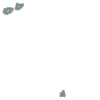

In [6]:
fish_def['geometry'][3]

In [7]:
# Combine the original attributes with the buffer GeoDataFrame
fish_def = fish_def[['sci_name',"geometry_buffer"]].copy()
fish_def = fish_def.rename(columns={'geometry_buffer': 'geometry'})

In [10]:
# Be careful running this
with open('.cache/fish_def.pkl', 'wb') as f:
    pkl.dump(fish_def, f)

In [2]:
# with open('.cache/fish_def.pkl', 'rb') as f:
#     fish_def = pkl.load(f)

In [8]:
fish_def

sci_name  \
0            Pimelodus ornatus   
1       Phenacogaster calverti   
2            Lithoxus bovallii   
3         Rineloricaria wolfei   
4            Moenkhausia mikia   
...                        ...   
4903  Pimelodella avanhandavae   
4904   Auchenipterus demerarae   
4905    Bryconamericus osgoodi   
4906   Bujurquina megalospilus   
4907     Ernstichthys intonsus   

                                               geometry  
0     MULTIPOLYGON (((-69.16250 -14.76250, -69.16133...  
1     MULTIPOLYGON (((-38.09583 -5.81250, -38.09466 ...  
2     POLYGON ((-61.33133 2.02992, -61.45747 2.23174...  
3     MULTIPOLYGON (((-69.42973 -12.97721, -69.43277...  
4     MULTIPOLYGON (((-71.56667 1.12500, -71.57083 1...  
...                                                 ...  
4903  MULTIPOLYGON (((-44.40057 -21.46741, -44.40057...  
4904  MULTIPOLYGON (((-58.36446 6.04640, -58.36446 6...  
4905  MULTIPOLYGON (((-72.95612 -11.44223, -72.95221...  
4906  MULTIPOLYGON (((-72.71421 -9.41215, -72.71004 ...  
4907  POLYGON ((-76.10417 -0.44167, -76.10417 -0.441...  

[4908 rows x 2 columns]

In [9]:
# dummy codes
# unique_counts = int_basins_PAs.groupby(['HYBAS_ID', 'PROTECTED']).size().reset_index(name='counts')
# unique_counts
# unique_counts['HYBAS_ID'] = unique_counts['HYBAS_ID'].astype(int)
# assert (unique_counts['counts'] == 1).all(), "Not all values in 'counts' are equal to X"


HYBAS_ID  PROTECTED  counts
0       6.120000e+09        0.0       1
1       6.120000e+09        1.0       1
2       6.120000e+09        0.0       1
3       6.120000e+09        0.0       1
4       6.120000e+09        0.0       1
...              ...        ...     ...
160579  6.121362e+09        0.0       1
160580  6.121362e+09        1.0       1
160581  6.121362e+09        0.0       1
160582  6.121362e+09        0.0       1
160583  6.121362e+09        0.0       1

[160584 rows x 3 columns]

In [16]:
# Now, can run tmp_fish.py to get the intersection between basins and fish data
# The resulting batched results are in files: fish_output_{batch_id}.pkl
# In the result, each line is a basin unit with the information of the fishes in that basin unit. 
# For example id_no is the set of fish IDs in that basin unit, sci_name is the set of fish names.

# For example you can check one pkl file
with open('.cache/batched_output/final_output_1.pkl', 'rb') as f:
    data1 = pkl.load(f)
data1

# From here we are good to go. You can just concatenate the results from all pkl files. And then perform the analysis.
# All the codes below haven't been cleaned (and I'm not able to run it through for some possibly outdated ones). But you shouldn't need them.

HYBAS_ID    MAIN_BAS  PROTECTED  \
0      6120155780  6030004470        0.0   
1      6120155790  6030004470        0.0   
2      6120155800  6030007000        0.0   
3      6120155810  6030007000        0.0   
4      6120155810  6030007000        1.0   
...           ...         ...        ...   
19995  6120320670  6030007000        0.0   
19996  6120320680  6030007000        0.0   
19997  6120320690  6030007000        0.0   
19998  6120320700  6030007000        0.0   
19999  6120320710  6030007000        1.0   

                                                geometry        AREA  \
0      POLYGON ((-72.01667 2.82917, -72.01601 2.83660...   43.080410   
1      POLYGON ((-71.93750 2.83333, -71.93785 2.83576...   11.698850   
2      POLYGON ((-67.84583 2.79583, -67.84655 2.80334...  176.220443   
3      POLYGON ((-61.87116 2.79648, -61.87703 2.79231...   29.031832   
4      POLYGON ((-61.89238 2.88839, -61.89110 2.89804...  189.890087   
...                                                  ...         ...   
19995  POLYGON ((-64.12917 -4.70000, -64.15417 -4.700...  123.137647   
19996  POLYGON ((-63.36667 -4.64167, -63.37826 -4.641...  140.851916   
19997  POLYGON ((-63.23333 -4.70833, -63.23450 -4.703...  120.662731   
19998  POLYGON ((-59.18333 -4.60417, -59.18750 -4.604...   23.154121   
19999  POLYGON ((-57.06215 -4.70591, -57.05869 -4.702...  177.531592   

       uniqueID                                              id_no  \
0         20000  {49829888, 49829891, 85281797, 49829893, 49830...   
1         20001  {49829888, 49829891, 85281797, 49829893, 49830...   
2         20002  {49829888, 49829891, 49829893, 164583437, 1627...   
3         20004  {49829888, 49829891, 49829893, 162748434, 4982...   
4         20003  {49829888, 49829891, 49829893, 162748434, 4982...   
...         ...                                                ...   
19995     39995  {49829888, 49829891, 186373, 49829893, 4982989...   
19996     39996  {49829888, 49829891, 186373, 49829893, 4982989...   
19997     39997  {49829888, 49829891, 186373, 49829893, 4982989...   
19998     39998  {49829888, 49829891, 186373, 49829893, 4982989...   
19999     39999  {49829888, 49829891, 186373, 49829893, 4982989...   

                                                sci_name  
0      {Hypostomus hemicochliodon, Microglanis poecil...  
1      {Hypostomus hemicochliodon, Microglanis poecil...  
2      {Hypostomus hemicochliodon, Hyphessobrycon rhe...  
3      {Hypostomus hemicochliodon, Boulengerella cuvi...  
4      {Hypostomus hemicochliodon, Boulengerella cuvi...  
...                                                  ...  
19995  {Hypostomus hemicochliodon, Boulengerella cuvi...  
19996  {Hypostomus hemicochliodon, Boulengerella cuvi...  
19997  {Hypostomus hemicochliodon, Boulengerella cuvi...  
19998  {Hypostomus hemicochliodon, Boulengerella cuvi...  
19999  {Hypostomus hemicochliodon, Boulengerella cuvi...  

[20000 rows x 8 columns]

In [ ]:
# -------------------------------- END ------------------------------------------------

# All the codes below haven't been cleaned but you shouldn't need them

In [15]:
#create a pivot table to get unique values of presence by basin and species
pivot_table=data1.pivot_table('HYBAS_ID', index='uniqueID', columns='sci_name', aggfunc='count')
pivot_table = pivot_table.fillna(0)

TypeError: unhashable type: 'set'

In [25]:
# just some codes to check how many basins in each MAIN_BA

cnts = int_basins_PAs['MAIN_BAS'].value_counts()
# unique_counts = sorted(u)
sorted_counts = cnts.sort_values()

# To display the unique values and their counts
# print(type(unique_counts))
# print(sorted(unique_counts))
print(sorted_counts)
print('(', ' '.join(map(lambda x: str(int(x)), sorted_counts.index)), ')')

MAIN_BAS
6030040020        5
6030016980      189
6030006540      389
6030007960      656
6030000010      747
6030007010      991
6030032290     2125
6030008320     2321
6030029280     2610
6030009770     2673
6030040460     2729
6030009760     2812
6030000740     2853
6030000750     2876
6030040470     2917
6030021870     2943
6030017370     3205
6030018850     3599
6030026140     3660
6030004480     5369
6030014330     5505
6030011790     5551
6030011780     5795
6030018860     6128
6030007950     6658
6030004470     8947
6030016970    22696
6030007000    53635
Name: count, dtype: int64


In [ ]:
#create a pivot table to get unique values of presence by basin and species
pivot_table=arc_ident_output.pivot_table('HYBAS_ID', index='uniqueID', columns='sci_name', aggfunc='count')
pivot_table = pivot_table.fillna(0)

In [9]:
# merge with existing columns info
merged_table= pd.merge(int_basins_PAs_perMainBA, pivot_table, on='uniqueID', how='inner')
pd.set_option('display.float_format', lambda x: '{:.0f}'.format(x))
merged_table.head(20)

HYBAS_ID   MAIN_BAS  PROTECTED  \
0  6120007960 6030007960          0   
1  6120007970 6030007960          0   
2  6120007980 6030007960          0   
3  6120007990 6030007960          0   
4  6120008000 6030007960          0   
5  6120008010 6030007960          0   
6  6120008020 6030007960          0   
7  6120008030 6030007960          0   
8  6120008040 6030007960          0   
9  6120008050 6030007960          0   
10 6120008060 6030007960          0   
11 6120008070 6030007960          0   
12 6120008080 6030007960          1   
13 6120008080 6030007960          0   
14 6120008090 6030007960          0   
15 6120008090 6030007960          1   
16 6120008100 6030007960          0   
17 6120008110 6030007960          0   
18 6120008120 6030007960          0   
19 6120008130 6030007960          1   

                                             geometry  AREA  uniqueID  \
0   POLYGON ((-49.39167 -2.19583, -49.39517 -2.194...     0      1245   
1   MULTIPOLYGON (((-49.35417 -2.22917, -49.35493 ...   106      1246   
2   POLYGON ((-49.28333 -2.20000, -49.28390 -2.197...   146      1247   
3   MULTIPOLYGON (((-49.29583 -2.02500, -49.28827 ...   341      1248   
4   MULTIPOLYGON (((-48.88333 -1.59167, -48.88390 ...   268      1249   
5   POLYGON ((-48.97500 -1.80000, -48.97500 -1.795...    19      1250   
6   POLYGON ((-48.92083 -1.79167, -48.92304 -1.791...    11      1251   
7   POLYGON ((-48.84583 -1.85000, -48.84678 -1.846...   159      1252   
8   POLYGON ((-48.90417 -1.73750, -48.91667 -1.737...    55      1253   
9   POLYGON ((-48.75833 -1.75417, -48.75918 -1.750...   129      1254   
10  POLYGON ((-48.70417 -1.70000, -48.70473 -1.697...   204      1255   
11  POLYGON ((-48.67917 -1.47083, -48.67917 -1.462...   117      1256   
12  MULTIPOLYGON (((-48.54167 -1.35833, -48.54216 ...    42      1257   
13  MULTIPOLYGON (((-48.55000 -1.26667, -48.54779 ...   293      1258   
14  POLYGON ((-48.56076 -1.62465, -48.56424 -1.621...   102      1259   
15  MULTIPOLYGON (((-48.52500 -1.52917, -48.51966 ...     1      1260   
16  POLYGON ((-48.51667 -1.54583, -48.51667 -1.533...     1      1261   
17  POLYGON ((-48.43333 -1.65833, -48.43750 -1.658...   184      1262   
18  POLYGON ((-48.50417 -1.52917, -48.50481 -1.527...     3      1263   
19  POLYGON ((-48.48688 -1.49909, -48.48112 -1.500...     3      1264   

    Acanthicus adonis  Acanthicus hystrix  Acarichthys heckelii  \
0                   0                   1                     1   
1                   0                   1                     1   
2                   0                   1                     1   
3                   0                   1                     1   
4                   0                   1                     1   
5                   0                   1                     1   
6                   0                   1                     1   
7                   0                   1                     1   
8                   0                   1                     1   
9                   0                   1                     1   
10                  0                   1                     1   
11                  0                   1                     1   
12                  0                   1                     1   
13                  0                   1                     1   
14                  0                   1                     1   
15                  0                   1                     1   
16                  0                   1                     1   
17                  0                   1                     1   
18                  0                   1                     1   
19                  0                   1                     1   

    Acestrorhynchus falcatus  Acestrorhynchus falcirostris  \
0                          1                             1   
1                          1                             1   
2                          1                             

In [10]:
len(merged_table)

656

In [12]:
#save as shapefile
merged_table.to_file("basin_species/6030007960/HA12_int_PAs_6030007960.shp")

/tmp/ipykernel_1959328/911340946.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_table.to_file("basin_species/6030007960/HA12_int_PAs_6030007960.shp")


In [13]:
#save as csv
csv_merged_table=merged_table.drop(columns='geometry')
csv_merged_table.to_csv("basin_species/6030007960/HA12_int_PAs_fishes_python.csv")                     

In [12]:
# for idx, row in int_basins_PAs.iterrows():
#     print(idx)
#     print(row)

In [16]:
color_current_protected = 'green'
color_non_protected = '#1f77b4'
# color_new_protected = 'orange'
# int_basins_PAs['color'] = int_basins_PAs.apply(lambda row: color_current_protected if row['PROTECTED']==1.0 else color_non_protected)

/tmp/ipykernel_3677977/1981805841.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


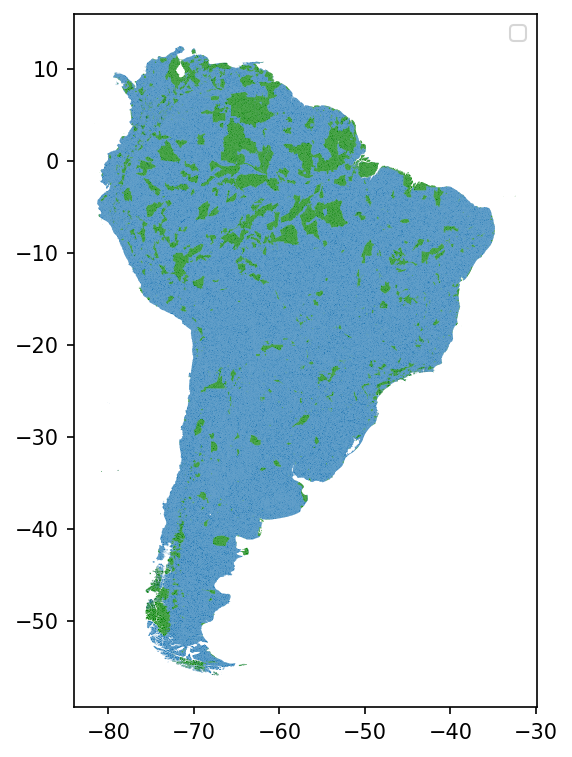

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
int_basins_PAs[int_basins_PAs['PROTECTED'] == 1.0].plot(ax=ax, color=color_current_protected, label='Protected')
int_basins_PAs[int_basins_PAs['PROTECTED'] != 1.0].plot(ax=ax, color=color_non_protected, label='Non-Protected')

main_basins_outline = int_basins_PAs.dissolve(by='MAIN_BAS')

# Plot the outlines of main basins
main_basins_outline.boundary.plot(ax=ax, color='black', linewidth=1, label='Main Basin Outline')

# Adding legend
ax.legend()


# Show plot
plt.show()

/tmp/ipykernel_3677977/2346501324.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


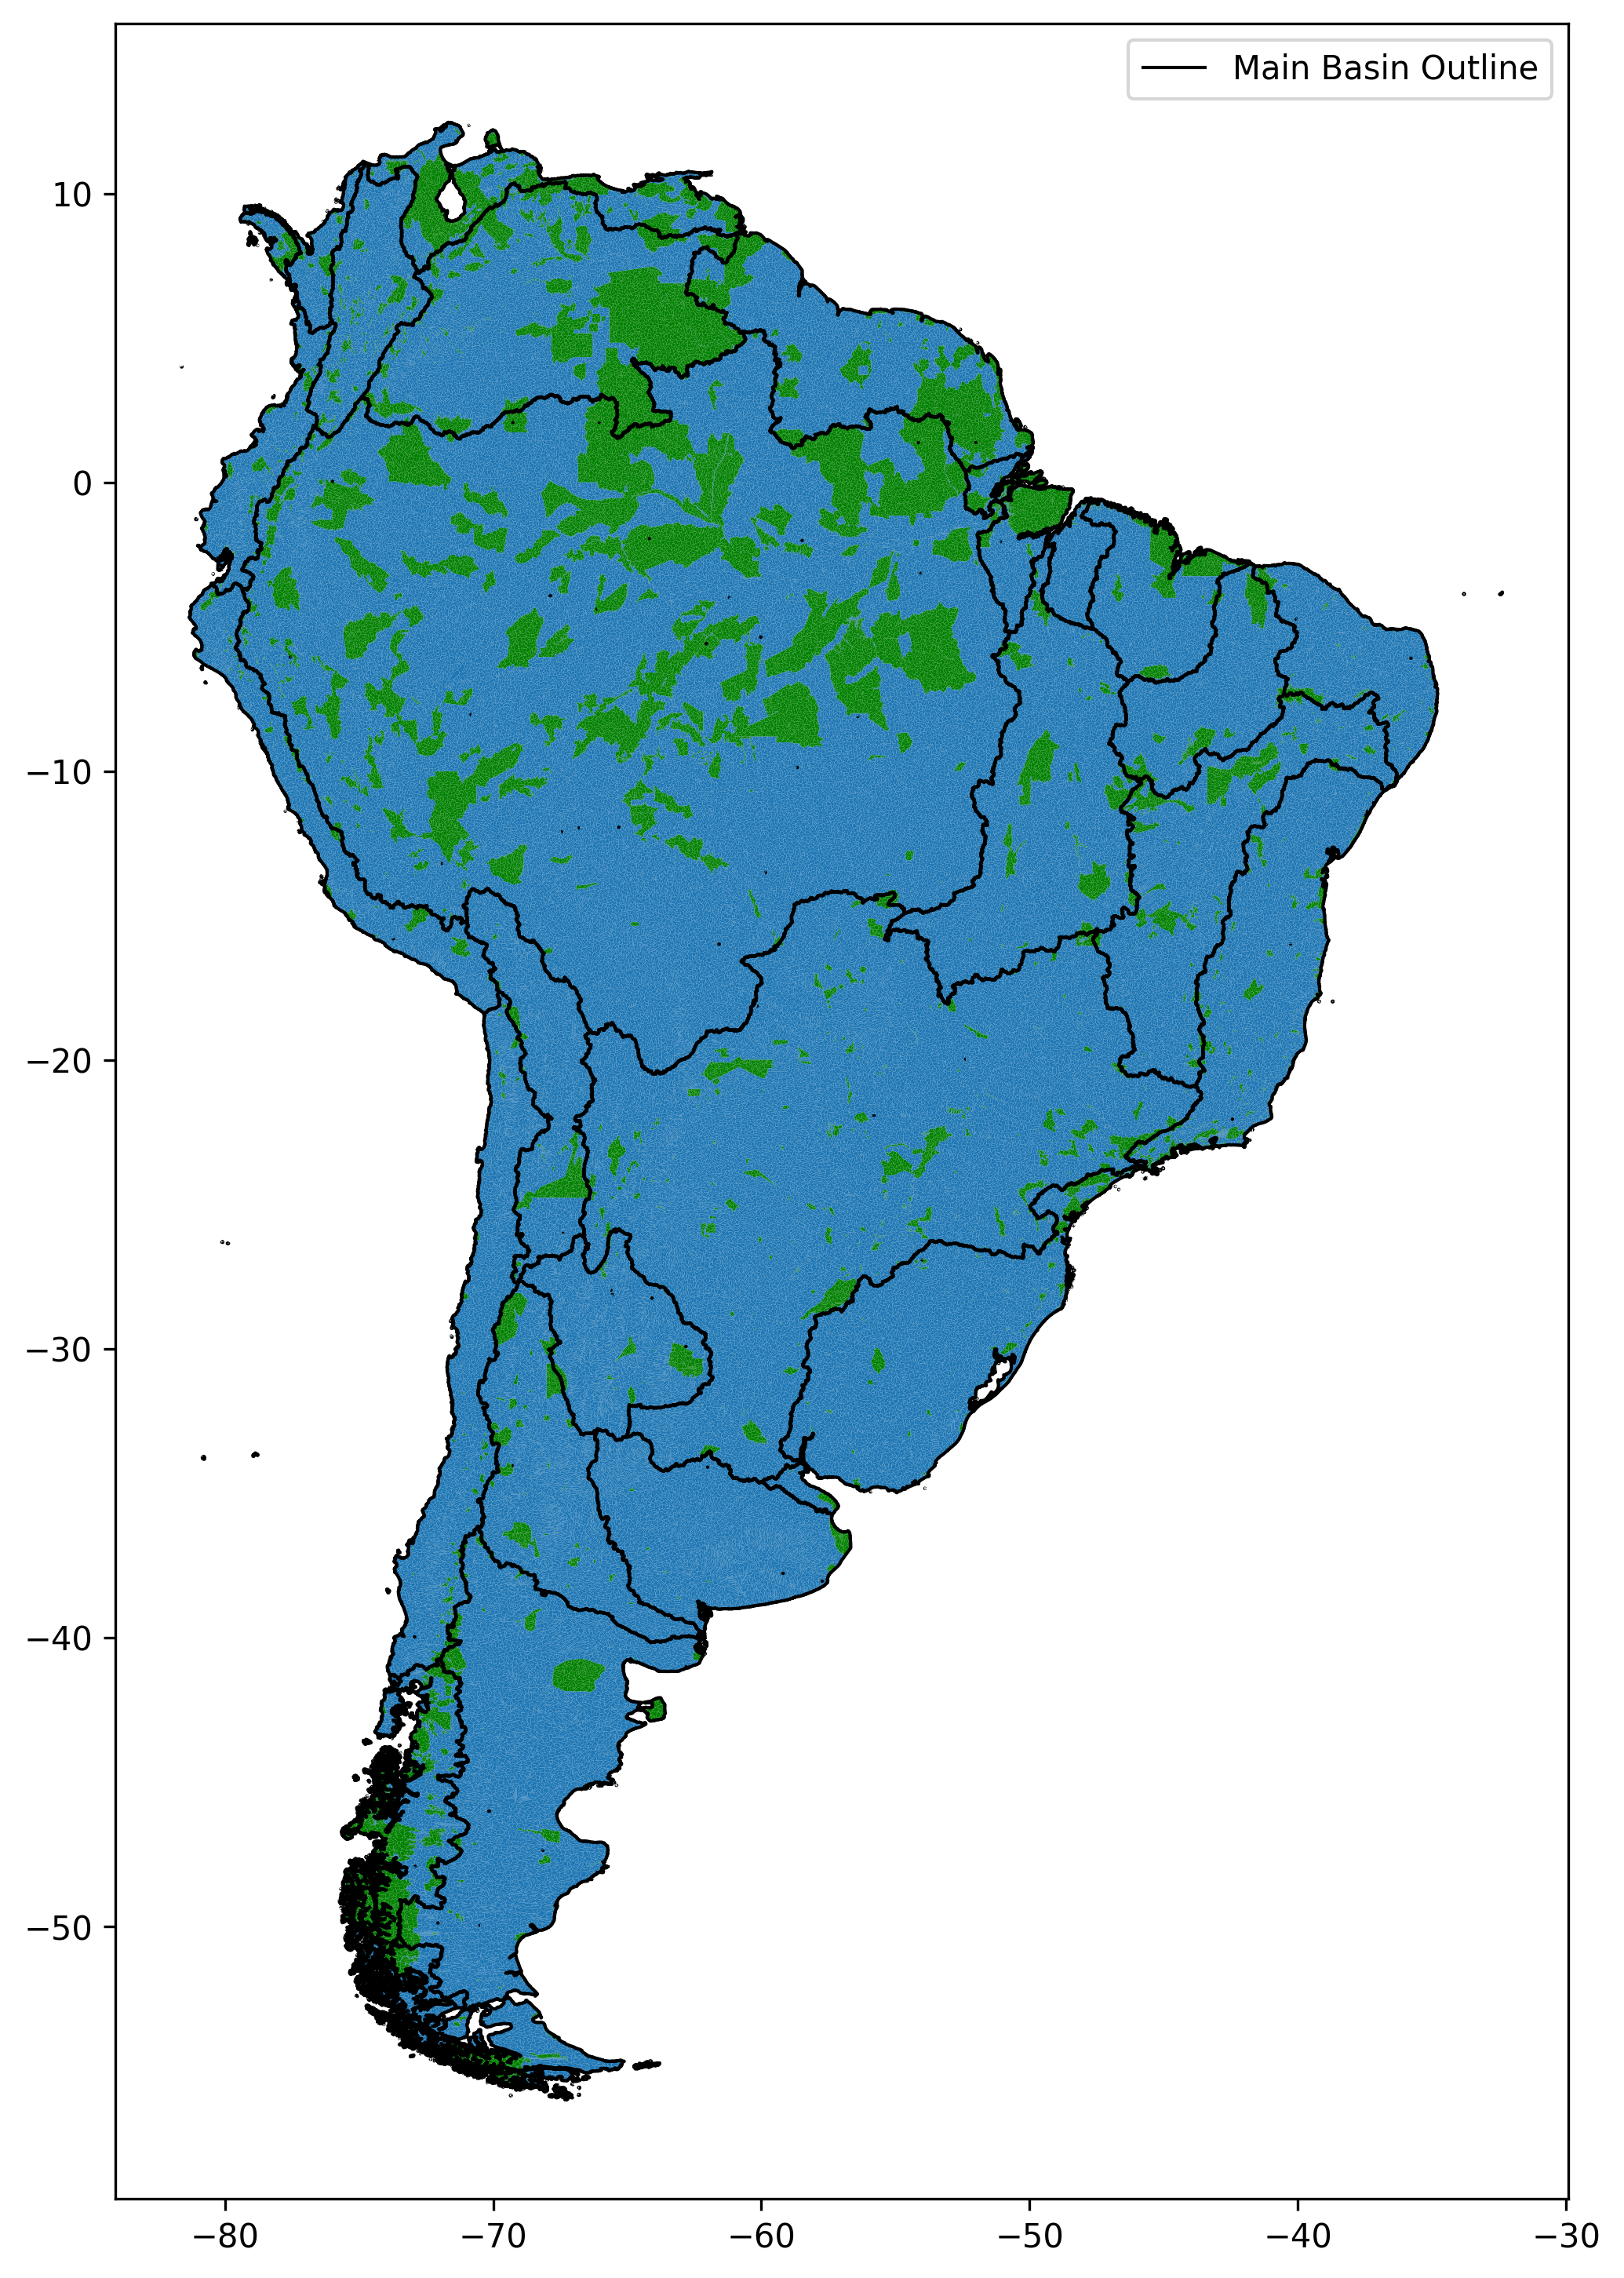

In [15]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=300)
int_basins_PAs[int_basins_PAs['PROTECTED'] == 1.0].plot(ax=ax, color=color_current_protected, label='Protected')
int_basins_PAs[int_basins_PAs['PROTECTED'] != 1.0].plot(ax=ax, color=color_non_protected, label='Non-Protected')

main_basins_outline = int_basins_PAs.dissolve(by='MAIN_BAS')

# Plot the outlines of main basins
main_basins_outline.boundary.plot(ax=ax, color='black', linewidth=1, label='Main Basin Outline')

# Adding legend
ax.legend()


# Show plot
plt.show()

In [18]:
int_basins_PAs['area'] = int_basins_PAs.geometry.area

# Group by 'MAIN_BAS' and calculate total and protected area
basin_area_summary = int_basins_PAs.groupby('MAIN_BAS').apply(lambda g: pd.Series({
    'Total_Area': g['area'].sum(),  # Total area for the main basin
    'Protected_Area': g[g['PROTECTED'] == 1.0]['area'].sum(),  # Area of protected parts
    'Protected_Ratio': g[g['PROTECTED'] == 1.0]['area'].sum() / g['area'].sum()  # Ratio of protected area
})).reset_index()

basin_area_summary

/tmp/ipykernel_3677977/3429353561.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  int_basins_PAs['area'] = int_basins_PAs.geometry.area


MAIN_BAS  Total_Area  Protected_Area  Protected_Ratio
0   6.030000e+09    5.908199        0.759651         0.128576
1   6.030001e+09   21.238186        2.551582         0.120141
2   6.030001e+09   21.829666       11.126484         0.509696
3   6.030004e+09   76.569883       28.938043         0.377930
4   6.030004e+09   45.807180       13.879979         0.303009
5   6.030007e+09    3.021223        1.344230         0.444929
6   6.030007e+09  483.768566      116.109765         0.240011
7   6.030007e+09    8.810652        3.635213         0.412593
8   6.030008e+09   63.831247        6.257747         0.098036
9   6.030008e+09    6.714656        0.115763         0.017240
10  6.030008e+09   22.137575        4.598142         0.207708
11  6.030010e+09   27.162862        2.707252         0.099667
12  6.030010e+09   23.369243        1.262230         0.054012
13  6.030012e+09   53.093711        6.483006         0.122105
14  6.030012e+09   48.692822        3.698142         0.075948
15  6.030014e+09   59.544473        2.761143         0.046371
16  6.030017e+09  233.209373       13.070209         0.056045
17  6.030017e+09    1.913185        0.225715         0.117979
18  6.030017e+09   39.416823        0.700725         0.017777
19  6.030019e+09   39.413061        3.936194         0.099870
20  6.030019e+09   80.035561        5.628659         0.070327
21  6.030022e+09   42.142544       14.822015         0.351711
22  6.030026e+09   39.237076        1.257792         0.032056
23  6.030029e+09   24.223556        1.793137         0.074024
24  6.030032e+09   17.008955        2.164016         0.127228
25  6.030040e+09    0.014523        0.010669         0.734623
26  6.030040e+09   28.692309        1.783752         0.062168
27  6.030040e+09   28.322777        2.512543         0.088711

In [3]:
with open('.cache/batched_output/final_output_1.pkl', 'rb') as f:
    data = pkl.load(f)
    # data = pkl.load(f)

In [3]:
data

HYBAS_ID    MAIN_BAS  PROTECTED  \
0      6120000010  6030000010        0.0   
1      6120000010  6030000010        1.0   
2      6120000020  6030000010        0.0   
3      6120000030  6030000010        0.0   
4      6120000040  6030000010        0.0   
...           ...         ...        ...   
18361  6120155730  6030004480        0.0   
18362  6120155740  6030004480        1.0   
18363  6120155750  6030032290        0.0   
18364  6120155760  6030004470        0.0   
18365  6120155770  6030004470        0.0   

                                                geometry        AREA  \
0      MULTIPOLYGON (((-78.95126 9.54998, -78.95750 9...  203.286676   
1      POLYGON ((-79.26720 9.42725, -79.27030 9.43109...   17.915474   
2      POLYGON ((-79.10000 9.40417, -79.10035 9.40659...   70.898202   
3      MULTIPOLYGON (((-79.09583 9.33333, -79.10833 9...  114.441867   
4      POLYGON ((-79.09167 9.30000, -79.09082 9.30332...  119.254719   
...                                                  ...         ...   
18361  POLYGON ((-58.93750 2.74167, -58.93750 2.74583...  165.872581   
18362  POLYGON ((-54.02083 2.77083, -54.02415 2.77168...   84.692760   
18363  POLYGON ((-77.49583 2.76250, -77.49804 2.76307...   41.060234   
18364  POLYGON ((-73.10417 2.77500, -73.10473 2.77721...   63.058806   
18365  POLYGON ((-72.01667 2.82917, -72.02083 2.82917...  126.544956   

       uniqueID                                              id_no  \
0             1  {49829891, 185872, 186393, 149249053, 188471, ...   
1             0  {138525825, 49829891, 191108, 185989, 185990, ...   
2             2  {138525825, 49829891, 191108, 185989, 185990, ...   
3             3  {49829891, 185872, 186393, 149249053, 188471, ...   
4             4  {49829891, 185872, 186393, 149249053, 53876256...   
...         ...                                                ...   
18361     19995  {49829888, 49829891, 85281797, 49830408, 16449...   
18362     19996  {49829891, 49830408, 164540945, 49830419, 1645...   
18363     19997  {138525825, 178064, 183453, 183331, 168626851,...   
18364     19998  {49829888, 49829891, 85281797, 49829893, 49830...   
18365     19999  {49829888, 49829891, 85281797, 49829893, 49830...   

                                                sci_name  
0      {Caranx hippos, Eucinostomus havana, Lophogobi...  
1      {Guavina guavina, Microphis brachyurus, Brachy...  
2      {Guavina guavina, Microphis brachyurus, Roeboi...  
3      {Caranx hippos, Lophogobius cyprinoides, Gobio...  
4      {Caranx hippos, Lophogobius cyprinoides, Gobio...  
...                                                  ...  
18361  {Potamoglanis hasemani, Bryconops affinis, Aca...  
18362  {Pimelodella leptosoma, Bryconops affinis, Ana...  
18363  {Trinectes fluviatilis, Atherinella colombiens...  
18364  {Potamoglanis hasemani, Eigenmannia macrops, S...  
18365  {Potamoglanis hasemani, Eigenmannia macrops, S...  

[18366 rows x 8 columns]

In [21]:
print(aggregates['uniqueID'])

0      160003
1      160006
2      160008
3      160009
4      160011
        ...  
242    160579
243    160580
244    160581
245    160582
246    160583
Name: uniqueID, Length: 247, dtype: int64
